In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np 
import scipy.stats as stats
from scipy.stats import pearsonr
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

## WeGO Data Dictionary
​
A trip is defined as one run of the vehicle from one end of the route to another in one direction. Two trips = one round trip. The TRIP_ID field provides a unique indicator for each trip.
​
- CALENDAR_ID: Identifier for the date
- SERVICE_ABBR: Service Type. indicates the schedule type operating that day. 1 = Weekday, 2 = Saturday, 3 = Sunday. Normally this corresponds to the day of the week, but sometimes Saturday or Sunday service will run on a weekday (i.e. during a holiday).
- ADHERENCE_ID: Unique identifier for each record
- DATE: Trip date
- ROUTE_ABBR: Route identifier. Routes can be found here https://www.wegotransit.com/ride/maps-schedules/bus/. For example, Route 55 is Murfreesboro Pike
- BLOCK_ABBR: Indicates the section (block) of the route that the given stop is on
- OPERATOR: Indicates the operator (driver)
- TRIP_ID: Identifies the trip
- OVERLOAD_ID: signifies that the record is from a trip that was added by the dispatcher and was not part of the original schedule for the day. Usually, these are created when one vehicle breaks down and another is covering the same service. As far as the actual value, 0 means that this record was part of the original schedule, and anything other than 0 means it was added.
- ROUTE_DIRECTION_NAME: Which direction the trip is going; Either to downtown or from downtown
- TIME_POINT_ABBR: 
- ROUTE_STOP_SEQUENCE: 
- TRIP_EDGE: defines whether the stop is the first one on the trip (1), an intermediate stop (0), or the last one on a trip (2)
- LATITUDE/LONGITUDE: Location in lat/long
- SCHEDULED_TIME: scheduled time
- ACTUAL_ARRIVAL_TIME: actual arrival time
- ACTUAL_DEPARTURE_TIME: actual departure time
- ADHERENCE: Difference between actual departure time and scheduled time; negative indicates departure time after scheduled time and positive indicates departure time before scheduled time.
- SCHEDULED_HDWY: Scheduled headway in minutes for the given timepoint crossing record; headway is the difference between the scheduled_time and the previous scheduled time for that stop
- ACTUAL_HDWY: Actual headway; Notably, does not exclude overloads, as we want to know about them for actual headway performance
- HDWY_DEV: calculates headway deviation in minutes as the difference between actual and scheduled headway. Negative values indicate a shorter headway than scheduled (i.e. bunching) and positive values indicate a longer headway than scheduled (i.e. gapping)	
- ADJUSTED_EARLY_COUNT: 	
- ADJUSTED_LATE_COUNT: 	
- ADJUSTED_ONTIME_COUNT: 
- STOP_CANCELLED:	flags whether a crossing was canceled or waived
- PREV_SCHED_STOP_CANCELLED: flags whether the previous timepoint crossing was cancelled or waived. Useful for excluding records where the headway values are extremely high because the bus is just coming off a detour
- IS_RELIEF: flags whether a particular crossing is a relief - i.e. the first timepoint crossing of a new driver on the bus/block	
- BLOCK_STOP_ORDER: 
- DWELL_IN_MINS: Actual Departure Time - Actual Arrival Time (in minutes)

In [2]:
headway_data = pd.read_csv("../data/headway_data.csv", delimiter = '\t')
headway_data.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,-0.144444
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,-0.258889


In [3]:
headway_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265884 entries, 0 to 265883
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                265884 non-null  int64  
 1   SERVICE_ABBR               265884 non-null  int64  
 2   ADHERENCE_ID               265884 non-null  int64  
 3   DATE                       265884 non-null  object 
 4   ROUTE_ABBR                 265884 non-null  int64  
 5   BLOCK_ABBR                 265884 non-null  int64  
 6   OPERATOR                   265884 non-null  int64  
 7   TRIP_ID                    265884 non-null  int64  
 8   OVERLOAD_ID                265884 non-null  int64  
 9   ROUTE_DIRECTION_NAME       265884 non-null  object 
 10  TIME_POINT_ABBR            265884 non-null  object 
 11  ROUTE_STOP_SEQUENCE        265884 non-null  float64
 12  TRIP_EDGE                  265884 non-null  int64  
 13  LATITUDE                   26

headway_data.to_csv('../data/headway_data.csv', sep='\t' , index=False)

In [4]:
bna_weather = pd.read_csv('../data/bna_weather.csv')

In [5]:
headway_data['HDWY_DEV_PERC'] = headway_data['HDWY_DEV']/headway_data['SCHEDULED_HDWY']
headway_data.head(5)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
0,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,-0.144444
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,-0.258889


How many routes on this data? 

In [7]:
bus_routes = sorted(headway_data['ROUTE_ABBR'].unique())
print(bus_routes)
print('Total:', len(bus_routes))

[3, 7, 22, 23, 50, 52, 55, 56]
Total: 8


3 - West End 

7 - Hillsboro 

22 - Bordeaux

23 - Dickerson Pike

50 - Charlotte Pike

52 - Nolensville Pike

55 - Murfreesboro Pike

56 - Gallatin Pike

In [8]:
routes = [3, 7, 22, 23, 50, 52, 55, 56]

In [9]:
headway_data['DATE'].unique()

array(['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04',
       '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08',
       '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-12',
       '2023-08-13', '2023-08-14', '2023-08-15', '2023-08-16',
       '2023-08-17', '2023-08-18', '2023-08-19', '2023-08-20',
       '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
       '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
       '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01',
       '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05',
       '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09',
       '2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13',
       '2023-09-14', '2023-09-15', '2023-09-16', '2023-09-17',
       '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
       '2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25',
       '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29',
       '2023-09-30'], dtype=object)

**Data cleanup - DATE**

headway_data['DATE'] = headway_data['DATE'].dt.strftime("%m-%d-%Y")



In [10]:
headway_data.set_index('DATE', inplace = True)
headway_data

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,120230801,1,99457897,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
2023-08-01,120230801,1,99457898,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2023-08-01,120230801,1,99457899,22,2200,1040,345106,0,TO DOWNTOWN,CV23,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222
2023-08-01,120230801,1,99457901,22,2200,1040,345107,0,FROM DOWNTOWN,MCC5_10,...,-2.166667,0,0,1,0,0.0,0,97,10.800000,-0.144444
2023-08-01,120230801,1,99457902,22,2200,1040,345107,0,FROM DOWNTOWN,CV23,...,-3.883334,1,0,0,0,0.0,0,112,0.000000,-0.258889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,120230930,2,100406606,7,702,2312,353447,0,FROM DOWNTOWN,MCC5_9,...,6.716666,0,0,1,0,0.0,0,504,7.033333,0.223889
2023-09-30,120230930,2,100406609,7,702,2312,353448,0,TO DOWNTOWN,HBHS,...,4.916666,0,1,0,0,0.0,0,530,1.966666,0.163889
2023-09-30,120230930,2,100406610,7,702,2312,353448,0,TO DOWNTOWN,21BK,...,5.266666,0,1,0,0,0.0,0,539,0.000000,0.175556


**Data Visualization** 

I want to see the location of each stop on a specific route. 

Add the following data: 
- zipcode dataset (geojson file) from https://data.nashville.gov/Metro-Government/Zip-Codes/72um-tmbe. 
- bus stops data (csv) from https://data.nashville.gov/Transportation/WeGo-Transit-Bus-Stops/vfe9-k7vc. 

In [11]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')

bus_stops = pd.read_csv('../data/WeGo_Transit_Bus_Stops_20231025.csv')

In [12]:
zipcodes.head(3)

,zipcode,poname,created_date,objectid,globalid,created_user,last_edited_date,last_edited_user,geometry
0,37218,NASHVILLE,None,55,{3CB897BE-ACCB-46CB-BA4E-6F5E39D6C451},None,None,None,"MULTIPOLYGON (((-86.88231 36.26248, -86.88270 ..."
1,37080,JOELTON,None,32,{C63ADE44-CC5E-4CCD-BBF0-4B8A64864B42},None,None,None,"MULTIPOLYGON (((-86.90742 36.39053, -86.90725 ..."
2,37027,BRENTWOOD,None,44,{8846D4AC-5F8A-4434-8348-C9A28297FA4E},None,None,None,"MULTIPOLYGON (((-86.67793 35.98782, -86.67941 ..."


In [13]:
bus_stops['lat'] = bus_stops['Mapped Location'].str.split(',', expand = True)[0].str.strip('(').astype(float)
bus_stops['lng'] = bus_stops['Mapped Location'].str.split(',', expand = True)[1].str.strip(')').astype(float)
bus_stops.head()

,Stop ID,Stop Abbreviation,Stop Name,Shelter?,Bench?,Route Numbers,Route Name,Mapped Location,lat,lng
0,5120,7AVUNINN,7TH AVE & UNION ST NB,False,False,NaN,AIRPORT - DOWNTOWN HOTELS,NaN,NaN,NaN
1,5455,CM5_4,Temporary Bay 4,False,False,NaN,HERMAN,NaN,NaN,NaN
2,2762,23ACLASF,23RD AVE N & CLARKSVILLE PIKE SB,False,False,22,BORDEAUX,NaN,NaN,NaN
3,4079,21ACHUSN,21ST AVE N & CHURCH ST SB,False,True,25,MIDTOWN,NaN,NaN,NaN
4,4133,GRWHIWN,GREEN LN & WHITES CREEK PIKE WB,False,False,41,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722


**Change bus_stops DataFrame to a GeoDataFrame** 

We need geometry and crs (coordinate reference system) 
- Add geometry from lat and long columns. 
- Use crs from zipcodes data. 
- Convert to GeoDataFrame, which has three parameters: a DataFrame, CRS, and geometry. 

In [14]:
bus_stops['geometry'] = gpd.points_from_xy(bus_stops['lng'], bus_stops['lat'])
bus_geo = gpd.GeoDataFrame(bus_stops, 
                           crs = zipcodes.crs, 
                           geometry = bus_stops['geometry'])
bus_geo.head()

C:\Users\MJ\anaconda3\Lib\site-packages\shapely\io.py:106: RuntimeWarning: invalid value encountered in to_wkt
  return lib.to_wkt(
C:\Users\MJ\anaconda3\Lib\site-packages\shapely\io.py:106: RuntimeWarning: invalid value encountered in to_wkt
  return lib.to_wkt(


,Stop ID,Stop Abbreviation,Stop Name,Shelter?,Bench?,Route Numbers,Route Name,Mapped Location,lat,lng,geometry
0,5120,7AVUNINN,7TH AVE & UNION ST NB,False,False,NaN,AIRPORT - DOWNTOWN HOTELS,NaN,NaN,NaN,POINT (nan nan)
1,5455,CM5_4,Temporary Bay 4,False,False,NaN,HERMAN,NaN,NaN,NaN,POINT (nan nan)
2,2762,23ACLASF,23RD AVE N & CLARKSVILLE PIKE SB,False,False,22,BORDEAUX,NaN,NaN,NaN,POINT (nan nan)
3,4079,21ACHUSN,21ST AVE N & CHURCH ST SB,False,True,25,MIDTOWN,NaN,NaN,NaN,POINT (nan nan)
4,4133,GRWHIWN,GREEN LN & WHITES CREEK PIKE WB,False,False,41,GOLDEN VALLEY,"(36.236249, -86.816722)",36.236249,-86.816722,POINT (-86.81672 36.23625)


In [15]:
type(bus_geo)

geopandas.geodataframe.GeoDataFrame

C:\Users\MJ\anaconda3\Lib\site-packages\shapely\measurement.py:106: RuntimeWarning: invalid value encountered in bounds
  return lib.bounds(geometry_arr, out=out, **kwargs)


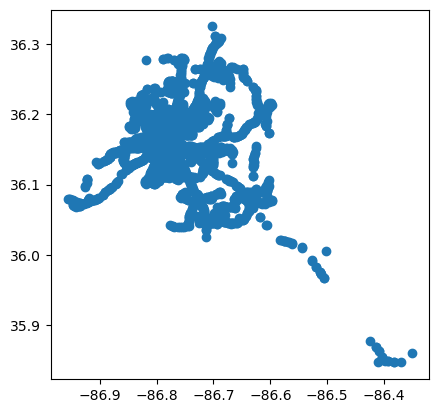

In [16]:
bus_geo.plot();

In [25]:
route3 = headway_data[headway_data['ROUTE_ABBR'] == 3]
route3['TRIP_ID'].unique()

array([346050, 346051, 346052, 346053, 346054, 346055, 346056, 346058,
       346059, 346060, 346061, 346063, 346064, 346065, 346066, 346067,
       346068, 346069, 346070, 346071, 346072, 346073, 346074, 346075,
       346076, 346077, 346138, 346139, 346140, 346141, 346142, 346143,
       346144, 346145, 346146, 346147, 346148, 346149, 346150, 346151,
       346152, 346153, 346154, 346155, 346200, 346201, 346202, 346203,
       346204, 346205, 346206, 346207, 346208, 346209, 346210, 346211,
       346212, 346213, 346214, 346215, 346216, 346217, 346218, 346219,
       346220, 346221, 346222, 346223, 346224, 346225, 346226, 346227,
       346228, 346229, 346230, 346231, 346240, 346241, 346242, 346243,
       346280, 346281, 346282, 346283, 346284, 346285, 346286, 346287,
       346288, 346289, 346290, 346291, 346292, 346293, 346294, 346295,
       346324, 346325, 346362, 346363, 346364, 346365, 346366, 346367,
       346368, 346369, 346370, 346371, 346372, 346373, 346374, 346375,
      

In [28]:
filtered_data = headway_data[headway_data['TRIP_ID'] == 346050]
trip_edge_values = filtered_data['TRIP_EDGE']
print(trip_edge_values)


DATE
2023-08-01    1
2023-08-01    0
2023-08-01    0
2023-08-01    0
2023-08-02    1
2023-08-02    0
2023-08-02    0
2023-08-02    0
2023-08-03    1
2023-08-03    0
2023-08-03    0
2023-08-03    0
Name: TRIP_EDGE, dtype: int64


In [6]:
headway_data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC'],
      dtype='object')

In [33]:
random_sample = headway_data['TRIP_ID'].drop_duplicates().sample
random_sample

<bound method NDFrame.sample of DATE
2023-08-01    345106
2023-08-01    345107
2023-08-01    345108
2023-08-01    345109
2023-08-01    345110
               ...  
2023-08-13    350966
2023-08-13    351150
2023-08-13    351154
2023-08-17    353246
2023-09-25    351944
Name: TRIP_ID, Length: 3917, dtype: int64>

**3. How closely does lateness (ADHERENCE) correlate to headway?**

Independent variable belongs on the x-axis and dependent variable belongs on the y-axis.

- Target/ dependent variable (variable you're trying to predict) - headway deviation.
- Predictor/ independent variable (variable you use to make prediction) - adherence. 

Reminder that: 
- ADHERENCE: Difference between actual departure time and scheduled time; negative indicates departure time after scheduled time and positive indicates departure time before scheduled time.
- HDWY_DEV: calculates headway deviation in minutes as the difference between actual and scheduled headway. Negative values indicate a shorter headway than scheduled (i.e. bunching) and positive values indicate a longer headway than scheduled (i.e. gapping). 

**Work with a subset of the data** 

First 50 rows maybe? 

In [66]:
subset = headway_data.iloc[:49]
subset.to_csv('../data/subset.csv', sep='\t' , index=False)
subset.head(3)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC
DATE,,,,,,,,,,,,,,,,,,,,,
2023-08-01,120230801,1,99457897,22,2200,1040,345106,0,TO DOWNTOWN,MHSP,...,2.666666,0,0,1,0,0.0,0,63,13.216666,0.076190
2023-08-01,120230801,1,99457898,22,2200,1040,345106,0,TO DOWNTOWN,ELIZ,...,1.966666,0,0,1,0,0.0,0,70,0.000000,0.056190
2023-08-01,120230801,1,99457899,22,2200,1040,345106,0,TO DOWNTOWN,CV23,...,-0.483334,0,0,1,0,0.0,0,80,0.000000,-0.032222


In [60]:
# Filter the DataFrame for positive and neutral adherence values
positive_adherence = subset[subset['ADHERENCE'] > 1]
neutral_adherence = subset[(subset['ADHERENCE'] > -1) & (subset['ADHERENCE'] < 1)]
negative_adherence = subset[subset['ADHERENCE'] < -1]

# Calculate statistics for both subsets
positive_stats = positive_adherence['HDWY_DEV'].describe()
neutral_stats = neutral_adherence['HDWY_DEV'].describe()
negative_stats = negative_adherence['HDWY_DEV'].describe()

# Create a DataFrame with the combined statistics
sample_adherence_stats = pd.DataFrame({
    'Adherence Type': ['Positive', 'Neutral', 'Negative'],
    'Count': [positive_stats['count'], neutral_stats['count'], negative_stats['count']],
    'Mean': [positive_stats['mean'], neutral_stats['mean'], negative_stats['mean']],
    'Std': [positive_stats['std'], neutral_stats['std'], negative_stats['std']],
    'Min': [positive_stats['min'], neutral_stats['min'], negative_stats['min']],
    '25%': [positive_stats['25%'], neutral_stats['25%'], negative_stats['25%']],
    '50%': [positive_stats['50%'], neutral_stats['50%'], negative_stats['50%']],
    '75%': [positive_stats['75%'], neutral_stats['75%'], negative_stats['75%']],
    'Max': [positive_stats['max'], neutral_stats['max'], negative_stats['max']]
})

# Display the DataFrame
sample_adherence_stats

,Adherence Type,Count,Mean,Std,Min,25%,50%,75%,Max
0,Positive,3.0,-4.183334,1.211519,-5.516667,-4.70,-3.883334,-3.516667,-3.150000
1,Neutral,9.0,-1.659260,2.270709,-4.416667,-3.95,-0.850000,-0.383334,1.433333
2,Negative,37.0,0.564865,1.909741,-3.716667,-0.50,0.100000,1.966666,4.683333


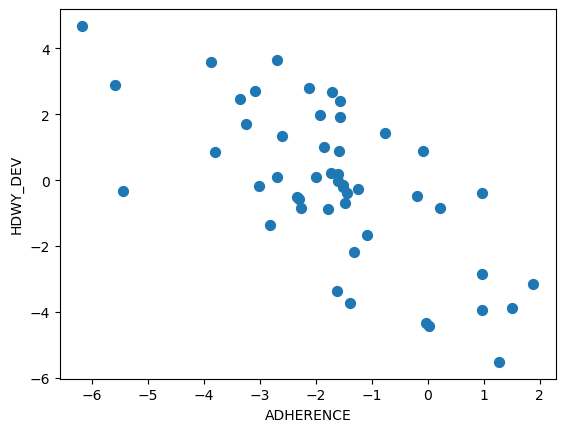

In [36]:
subset.plot.scatter(x = 'ADHERENCE', y = 'HDWY_DEV', s = 50);

This graphs shows that: 
- When the bus leaves before the scheduled departure time (positive ADHERENCE), the average time in minutes between the actual and scheduled headway (HDWY_DEV) is 4 minutes shorter (negative HDWY_DEV). 
- When the bus leaves about on time (neutral adherence), the avg waiting time between buses decreases by 1 min and a half (neg HDWY_DEV). 
- When the bus leaves after the scheduled departure time (negative ADHERENCE), the avg waiting time between is about the same (neutral HDWY_DEV). 

**Apply this to original data** 

In [63]:
# Filter the DataFrame for positive and neutral adherence values
positive_adherence = headway_data[headway_data['ADHERENCE'] > 1]
neutral_adherence = headway_data[(headway_data['ADHERENCE'] > -1) & (headway_data['ADHERENCE'] < 1)]
negative_adherence = headway_data[headway_data['ADHERENCE'] < -1]

# Calculate statistics for both subsets
positive_stats = positive_adherence['HDWY_DEV'].describe()
neutral_stats = neutral_adherence['HDWY_DEV'].describe()
negative_stats = negative_adherence['HDWY_DEV'].describe()

# Create a DataFrame with the combined statistics
adherence_stats = pd.DataFrame({
    'Adherence Type': ['Positive', 'Neutral', 'Negative'],
    'Count': [positive_stats['count'], neutral_stats['count'], negative_stats['count']],
    'Mean': [positive_stats['mean'], neutral_stats['mean'], negative_stats['mean']],
    'Std': [positive_stats['std'], neutral_stats['std'], negative_stats['std']],
    'Min': [positive_stats['min'], neutral_stats['min'], negative_stats['min']],
    '25%': [positive_stats['25%'], neutral_stats['25%'], negative_stats['25%']],
    '50%': [positive_stats['50%'], neutral_stats['50%'], negative_stats['50%']],
    '75%': [positive_stats['75%'], neutral_stats['75%'], negative_stats['75%']],
    'Max': [positive_stats['max'], neutral_stats['max'], negative_stats['max']]
})

# Display the DataFrame
adherence_stats

,Adherence Type,Count,Mean,Std,Min,25%,50%,75%,Max
0,Positive,8819.0,-3.695143,5.446979,-33.150000,-5.966667,-3.483334,-1.750000,78.050000
1,Neutral,72111.0,-1.677035,5.946462,-32.866667,-3.550000,-1.483334,-0.100000,498.066666
2,Negative,183992.0,1.590440,7.396909,-64.000000,-1.200000,1.166666,3.633333,565.433333


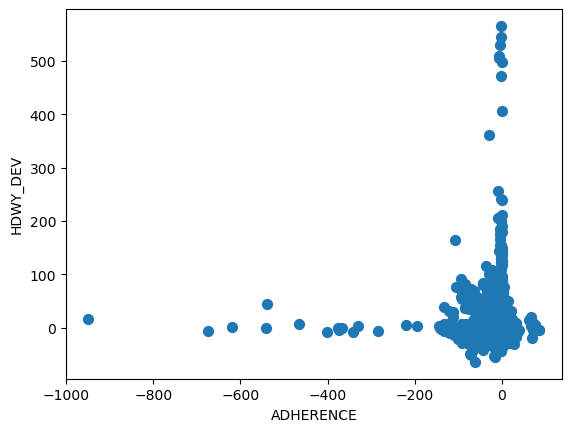

In [61]:
headway_data.plot.scatter(x = 'ADHERENCE', y = 'HDWY_DEV', s = 50);

In [62]:
# comparing to 'actual headway'
corr = headway_data['ADHERENCE'].corr(headway_data['HDWY_DEV'])

# comparing to 'headway deviation percentage'
corr2 = headway_data['ADHERENCE'].corr(headway_data['HDWY_DEV_PERC'])
print(corr)
print(corr2)

-0.20682243927838492
nan


In [18]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(headway_data['ADHERENCE'], headway_data['ACTUAL_HDWY'])

# Print the correlation coefficient
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Pearson Correlation Coefficient: -0.0748975006471459


There seems to be no correlation between the amount of time you wait at a stop in between buses and the amount of time was early or behind departure schedule. 

Fit a linear regression model on the data with target variable expectancy and predictor variable. 

Ex: 

lm = smf.ols('target variable ~ predictor variable', data = df).fit()

lm.summary()

In [64]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = headway_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                 1.188e+04
Date:                Sat, 28 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:21:36   Log-Likelihood:            -8.9492e+05
No. Observations:              265884   AIC:                         1.790e+06
Df Residuals:                  265882   BIC:                         1.790e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2802      0.015    -18.151      0.000      -0.310      -0.250
ADHERENCE     -0.2279      0.002   -109.002      0.000      -0.232      -0.224
==============================================================================
Omnibus:                   525134.358   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       9643452394.096
Skew:                          15.113   Prob(JB):                         0.00
Kurtosis:                     935.498   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For every one-minute increase in adherence, hdwy_dev is expected to decrease by approximately 0.2279 units.

In other words, as 'HDWY_DEV' becomes more negative (indicating shorter headway than scheduled, i.e., bunching), 'ADHERENCE' is expected to decrease, suggesting that adherence tends to be worse when buses are bunched. Conversely, when 'HDWY_DEV' becomes more positive (indicating longer headway than scheduled, i.e., gapping), 'ADHERENCE' is expected to increase, suggesting that adherence tends to be better when buses are more spaced out.

**1. How much impact does being late or too spaced out at the first stop have downstream?**

Independent variable (x) = HDWY_DEV at TRIP_EDGE = 1 

Dependent variables (y) = HDWY_DEV at other TRIP_EDGE (0, 2)

For each trip in every route, investigate the impact of how being late (HDWY_DEV) on the first stop impacts the other stops downstream.

*Is this question asking how adherence affects headway deviation in the other stops??*

Analyze how the value in the ACTUAL_HDWY column impacts its next few values and repeat this process that starts and stops at every occurrence of the value 1 in TRIP_EDGE column. 

- Target/ dependent variable (variable you're trying to predict) - headway deviation 
- Predictor/ independent variable (variable you use to make prediction) - adherence

In [20]:
# Initialize variables to keep track of the sequences
sequences = []  # List to store extracted sequences

# Iterate through the DataFrame
sequence = []  # List to build the current sequence
start_sequence = False

for index, row in headway_data.iterrows():
    value = row['ACTUAL_HDWY']
    start_stop = row['TRIP_EDGE']

    if start_stop == 1:
        # If a 1 is encountered in the 'START_STOP_COLUMN', start a new sequence
        start_sequence = True
        sequence = [value]
    elif start_sequence:  # Continue the sequence as long as it has started
        sequence.append(value)

    if start_stop == 0 and start_sequence:
        # If a 0 is encountered in the 'START_STOP_COLUMN' and there's an active sequence, mark the end
        sequences.append(sequence)
        start_sequence = False

# Analyze the impact of 'ACTUAL_HDWY' on its next few values for each sequence
for i, seq in enumerate(sequences, start=1):
    print(f'Sequence {i}: {seq}')
    # Here, you can analyze the impact of 'ACTUAL_HDWY' values in the sequence
    # Access the 'seq' list and perform your analysis on its elements

Sequence 1: [37.666666, 36.966666]
Sequence 2: [12.833333, 11.116666]
Sequence 3: [59.8, 60.083333]
Sequence 4: [15.233333, 14.616666]
Sequence 5: [62.733333, 16.0]
Sequence 6: [14.833333, 14.85]
Sequence 7: [61.35, 15.183333]
Sequence 8: [14.6, 10.483333]
Sequence 9: [55.1, 11.316666]
Sequence 10: [10.333333, 8.85]
Sequence 11: [8.633333, 9.283333]
Sequence 12: [47.166666, 13.433333]
Sequence 13: [14.8, 14.416666]
Sequence 14: [46.05, 7.583333]
Sequence 15: [11.166666, 11.416666]
Sequence 16: [50.9, 15.6]
Sequence 17: [13.933333, 12.9]
Sequence 18: [52.883333, 13.7]
Sequence 19: [10.633333, 12.866666]
Sequence 20: [52.45, 16.683333]
Sequence 21: [15.65, 17.866666]
Sequence 22: [44.866666, 27.166666]
Sequence 23: [26.45, 28.0]
Sequence 24: [54.166666, 30.816666]
Sequence 25: [37.316666, 36.8]
Sequence 26: [60.533333, 35.75]
Sequence 27: [31.166666, 31.783333]
Sequence 28: [59.983333, 33.066666]
Sequence 29: [30.75, 29.683333]
Sequence 30: [60.15, 25.966666]
Sequence 31: [19.683333, 40.

Sequence 27898: [26.65, 29.383333]
Sequence 27899: [24.8, 24.566666]
Sequence 27900: [18.75, 21.216666]
Sequence 27901: [15.15, 16.516666]
Sequence 27902: [20.216666, 24.25]
Sequence 27903: [12.516666, 18.516666]
Sequence 27904: [26.15, 27.533333]
Sequence 27905: [26.216666, 25.683333]
Sequence 27906: [21.366666, 20.833333]
Sequence 27907: [30.966666, 29.533333]
Sequence 27908: [22.483333, 22.833333]
Sequence 27909: [33.933333, 30.65]
Sequence 27910: [28.033333, 32.4]
Sequence 27911: [39.5, 39.466666]
Sequence 27912: [32.266666, 30.0]
Sequence 27913: [33.15, 33.116666]
Sequence 27914: [35.366666, 33.266666]
Sequence 27915: [38.85, 23.916666]
Sequence 27916: [22.8, 19.683333]
Sequence 27917: [44.433333, 26.35]
Sequence 27918: [22.766666, 7.233333]
Sequence 27919: [42.066666, 24.266666]
Sequence 27920: [22.85, 21.516666]
Sequence 27921: [36.616666, 20.083333]
Sequence 27922: [21.533333, 18.966666]
Sequence 27923: [37.916666, 15.866666]
Sequence 27924: [21.766666, 20.416666]
Sequence 2792

Sequence 58164: [13.666666, 9.366666]
Sequence 58165: [36.05, 36.45]
Sequence 58166: [12.683333, 11.166666]
Sequence 58167: [61.2, 61.4]
Sequence 58168: [15.05, 14.966666]
Sequence 58169: [63.383333, 11.733333]
Sequence 58170: [14.116666, 14.95]
Sequence 58171: [58.95, 12.933333]
Sequence 58172: [14.366666, 15.016666]
Sequence 58173: [54.583333, 8.1]
Sequence 58174: [13.45, 12.833333]
Sequence 58175: [51.0, 56.183333]
Sequence 58176: [14.233333, 13.8]
Sequence 58177: [46.166666, 14.616666]
Sequence 58178: [17.566666, 17.933333]
Sequence 58179: [51.3, 15.966666]
Sequence 58180: [11.183333, 11.466666]
Sequence 58181: [46.433333, 16.233333]
Sequence 58182: [14.966666, 16.05]
Sequence 58183: [50.15, 14.633333]
Sequence 58184: [13.866666, 11.783333]
Sequence 58185: [49.983333, 9.766666]
Sequence 58186: [18.233333, 19.883333]
Sequence 58187: [46.616666, 18.016666]
Sequence 58188: [22.466666, 24.533333]
Sequence 58189: [47.766666, 24.133333]
Sequence 58190: [32.35, 29.883333]
Sequence 58191: 

**4. What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has travelled?**